Purpose: Re-run PCA for final set of samples with >1 million reads. Also run a PCA for each genotype to check replicate numbers/clustering.<br>
Author: Anna Pardo<br>
Date initiated: Sept. 22, 2025

In [1]:
# load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


## Section 1: Define functions

In [2]:
# define a function from an answer in https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [3]:
# create a TPM data wrangling function - includes scaling
def tpm_prep(tpmmd):
    tpm = tpmmd.drop(["genotype","time","treat","ZT","species"],axis=1).set_index("sample_name")
    vttpm = variance_threshold_selector(tpm)
    print("Number of zero-variance genes removed:",len(tpm.columns)-len(vttpm.columns))
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    scale = StandardScaler()
    vttpm_log_scaled = pd.DataFrame(scale.fit_transform(vttpm_log))
    return vttpm_log_scaled, vttpm_log

In [4]:
# PCA running function (first 6 PCs)
def run_pca(vttpm_log_scaled):
    pca = PCA(n_components=6)
    real_PCs = pca.fit_transform(vttpm_log_scaled)
    real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
    print("Explained variance ratio:",pca.explained_variance_ratio_)
    return real_PCs_df

In [5]:
# Plot data formatting function
def make_plotdata(vttpm_log,tpmmd,pca):
    md = tpmmd[["sample_name","genotype","time","treat","ZT","species"]]
    ltpm = vttpm_log.reset_index()
    ltpmmd = ltpm.merge(md)
    ordered_md = ltpmmd[["sample_name","genotype","time","treat","ZT","species"]]
    plotdf = pd.concat([pca.reset_index(drop=True),ordered_md.reset_index(drop=True)],axis=1)
    return plotdf

In [6]:
# plotting function: by genotype
def plotpca_genotype(plotdf,fname,pc1ev,pc2ev,customtitle=""):
    # convert genotypes to strings
    plotdf["genotype"] = plotdf["genotype"].astype(str)
    if "18.0" in list(plotdf["genotype"].unique()):
        plotdf["genotype"] = plotdf["genotype"].replace(to_replace="18.0",value="18")
    # to color by genotype: split up the data
    sub_gtypes = []
    count = 0
    while count < 20:
        sub_gtypes.append(plotdf["genotype"].unique()[count])
        count += 1
        
    pdf1 = plotdf[plotdf["genotype"].isin(sub_gtypes)]
    pdf2 = plotdf[~plotdf["genotype"].isin(sub_gtypes)]
    
    ev1 = round(pc1ev*100,1)
    ev2 = round(pc2ev*100,1)
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=pdf1["PC1"],y=pdf1["PC2"],hue=pdf1["genotype"],palette="tab20b",s=75,alpha=0.75)
    sns.scatterplot(x=pdf2["PC1"],y=pdf2["PC2"],hue=pdf2["genotype"],palette="tab20c",s=75,alpha=0.75)
    plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=12)
    plt.xlabel("PC1 ("+str(ev1)+"%)",fontsize=16)
    plt.ylabel("PC2 ("+str(ev2)+"%)",fontsize=16)
    plt.title("PCA of logTPM by genotype "+customtitle,fontsize=20)
    plt.savefig(fname,dpi=200,bbox_inches="tight")

In [7]:
# plotting function: by treatment & ZT
def plotpca_treatzt(plotdf,fname,pc1ev,pc2ev,customtitle=""):
    ev1 = round(pc1ev*100,1)
    ev2 = round(pc2ev*100,1)
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["ZT"],style=plotdf["treat"],palette="winter",s=75,alpha=0.75)
    plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=12)
    plt.xlabel("PC1 ("+str(ev1)+"%)",fontsize=16)
    plt.ylabel("PC2 ("+str(ev2)+"%)",fontsize=16)
    plt.title("PCA of logTPM by treatment & time "+customtitle,fontsize=18)
    plt.savefig(fname+".pdf",dpi=200,bbox_inches="tight")
    plt.savefig(fname+".png",dpi=200,bbox_inches="tight")
    plt.savefig(fname+".svg",dpi=200,bbox_inches="tight")

In [8]:
def plotpca_latlong(plotdf,llinfo,fname,pc1ev,pc2ev,customtitle=""):
    # llinfo = metadata for lat/long filename
    llmd = pd.read_csv(llinfo,sep=",",header="infer",usecols=["Species","Genotype","Longitude","Latitude"],encoding='unicode_escape')
    # re-format genotype column
    gt = []
    for i in range(len(llmd.index)):
        gid = llmd.iloc[i,1].lstrip("Y")
        if gid.startswith("A"):
            gid = gid.lstrip("A")
        elif gid.startswith("F"):
            gid = gid.lstrip("F")
        elif gid.startswith("G"):
            gid = gid.lstrip("G")

        if gid == "Eudy":
            gt.append("Eu")
        elif gid =="":
            gt.append("G")
        else:
            gt.append(gid)
    llmd["genotype"]=gt
    plotdf = plotdf.merge(llmd[["genotype","Longitude","Latitude"]],on="genotype")
    
    ev1 = round(pc1ev*100,1)
    ev2 = round(pc2ev*100,1)
    
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,10))
    a = sns.scatterplot(ax=ax[0],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Latitude"],palette="RdYlBu",s=75,alpha=0.75)
    a.set_title("PCA of logTPM by Latitude "+customtitle,fontsize=16)
    a.set_xlabel("PC1 ("+str(ev1)+"%)",fontsize=16)
    a.set_ylabel("PC2 ("+str(ev2)+"%)",fontsize=16)
    b = sns.scatterplot(ax=ax[1],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Longitude"],palette="copper",s=75,alpha=0.75)
    b.set_title("PCA of logTPM by Longitude "+customtitle,fontsize=16)
    b.set_xlabel("PC1 ("+str(ev1)+"%)",fontsize=16)
    b.set_ylabel("PC2 ("+str(ev2)+"%)",fontsize=16)
    plt.savefig(fname,dpi=200,bbox_inches="tight")

## Section 2: Run & plot PCA for Y. gloriosa aligned to Y. gloriosa in silico genome

In [9]:
# load TPM
## only samples with more than 1 million reads (850 total)
ygtpm = pd.read_csv("./TPM/Yg_toYgIS_allTPM_correctedmd_over1mil.txt",sep="\t",header="infer")
ygtpm.head()

/tmp/ipykernel_111/2809466810.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ygtpm = pd.read_csv("./TPM/Yg_toYgIS_allTPM_correctedmd_over1mil.txt",sep="\t",header="infer")


,sample_name,genotype,time,treat,ZT,species,Yucal.01G000100.v2.1,Yucal.01G000200.v2.1,Yucal.01G000300.v2.1,Yucal.01G000400.v2.1,...,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g
0,Y1,18,1.0,W,1.0,gloriosa,34.002815,4.546167,0.0,17.236119,...,0.000000,6.167441,1.435253,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000
1,Y10,2AB,1.5,W,3.0,gloriosa,40.070758,3.628454,0.0,14.918115,...,0.713535,2.197522,15.695904,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000
2,Y100,2AB,6.5,W,23.0,gloriosa,47.402599,5.201760,0.0,17.406497,...,0.314746,2.261806,21.742515,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780
3,Y101,2AB,1.0,D,1.0,gloriosa,57.062380,6.374324,0.0,10.567561,...,0.000000,1.072366,27.573939,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682
4,Y103,2AB,1.0,D,1.0,gloriosa,34.679279,6.087451,0.0,11.115252,...,0.000000,0.914550,28.621412,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418


In [10]:
ygtpm["genotype"].unique()

array(['18', '2AB', '1AB', '19', '15', 'Eudy', 'G', '56', '36', 36, 18,
       13, '13', 45, '45', '52', '43', 52, '37', '48', '55', '70', '61',
       51, 70, 55, 61, 46, 43, 37, 53, 48, 16, 19, 6, 12, 20, 50],
      dtype=object)

In [12]:
# fix genotype column & overwrite TPM data
ygtpm["genotype"] = ygtpm["genotype"].astype(str)
ygtpm["genotype"].unique()

array(['18', '2AB', '1AB', '19', '15', 'Eudy', 'G', '56', '36', '13',
       '45', '52', '43', '37', '48', '55', '70', '61', '51', '46', '53',
       '16', '6', '12', '20', '50'], dtype=object)

In [13]:
ygtpm.to_csv("./TPM/Yg_toYgIS_allTPM_correctedmd_over1mil.txt")

In [15]:
vtyg_log_scaled, vtyg_log = tpm_prep(ygtpm)
vtyg_log_scaled.head()

Number of zero-variance genes removed: 1632


,0,1,2,3,4,5,6,7,8,9,...,84320,84321,84322,84323,84324,84325,84326,84327,84328,84329
0,0.348880,-0.834954,-0.334001,1.439502,1.058610,0.597207,0.866895,-0.146352,-0.622954,-0.284973,...,0.509444,-0.389983,0.505750,-1.181594,-0.992145,1.281659,-1.435665,-0.209007,-0.180784,-0.862790
1,0.729794,-1.454285,-0.334001,0.934510,-1.006967,-1.829420,-0.228190,-0.146352,-1.394524,-1.431366,...,2.402372,4.396797,-1.274647,0.639196,0.300767,0.871177,-2.129734,0.186032,1.046263,-0.862790
2,1.121166,-0.452414,-0.334001,1.474046,-0.321338,0.135712,2.197569,-0.146352,0.483551,0.740362,...,1.053028,2.042199,-1.230743,0.931520,0.884956,0.900193,-0.748742,0.023992,2.628176,1.007239
3,1.554729,0.140509,-0.334001,-0.251400,0.771591,1.286564,0.428850,-0.146352,-1.400973,-0.160834,...,0.606190,-0.389983,-2.231235,1.147409,0.269225,0.481889,-1.017653,0.425943,-0.939322,0.204265
4,0.394488,0.004654,-0.334001,-0.079559,0.845327,0.797885,0.081903,-0.146352,-1.223490,0.436473,...,0.207223,-0.389983,-2.405948,1.181461,-0.082746,-0.387573,-1.561844,0.412833,-0.891052,0.256597


In [16]:
pca_yg = run_pca(vtyg_log_scaled)

Explained variance ratio: [0.12703223 0.06629084 0.05858518 0.04585696 0.03641326 0.03190001]


In [42]:
vtyg_log.head()

,Yucal.01G000100.v2.1,Yucal.01G000200.v2.1,Yucal.01G000300.v2.1,Yucal.01G000400.v2.1,Yucal.01G000500.v2.1,Yucal.01G000600.v2.1,Yucal.01G000700.v2.1,Yucal.01G000800.v2.1,Yucal.01G000900.v2.1,Yucal.01G001000.v2.1,...,YufilH1095121m.g,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095147m.g
sample_name,,,,,,,,,,,,,,,,,,,,,
Y1,5.129399,2.471491,0.0,4.188727,2.140948,3.181674,3.168583,0.0,2.822003,4.896227,...,2.326881,0.000000,2.841458,1.284072,0.355103,3.634609,0.733139,1.529426,2.940186,0.000000
Y10,5.360040,2.210531,0.0,3.992598,1.456757,2.268756,2.622696,0.0,2.490560,4.410754,...,4.767747,0.776975,1.676954,4.061422,1.133074,3.481916,0.000000,1.684587,3.714329,0.000000
Y100,5.597013,2.632678,0.0,4.202143,1.683861,3.008056,3.831908,0.0,3.297325,5.330434,...,3.027815,0.394784,1.705671,4.507320,1.484592,3.492710,1.458730,1.620941,4.712356,1.505271
SRR10848707,4.765541,2.997438,0.0,3.199834,1.615254,2.934737,2.237266,0.0,3.079742,4.988607,...,0.000000,0.000000,2.184553,4.671192,0.923768,2.453303,3.501029,1.467963,2.188215,0.939012
SRR10848820,4.636617,2.974416,0.0,3.691061,2.062594,3.137316,2.586591,0.0,3.096606,5.340304,...,0.563173,0.000000,2.925617,1.580336,0.724569,2.990779,2.653062,2.027932,2.883271,0.000000


In [17]:
plot_yg = make_plotdata(vtyg_log,ygtpm,pca_yg)
plot_yg.head()

,PC1,PC2,PC3,PC4,PC5,PC6,sample_name,genotype,time,treat,ZT,species
0,-6.708725,-5.249458,-49.895864,138.401659,4.875572,-28.664176,Y1,18,1.0,W,1.0,gloriosa
1,70.907648,145.325769,-21.456288,68.250968,-26.234009,-58.141361,Y10,2AB,1.5,W,3.0,gloriosa
2,-133.086681,114.346170,71.767470,59.470277,0.311437,-15.596347,Y100,2AB,6.5,W,23.0,gloriosa
3,24.135755,144.562423,13.371663,108.838842,-24.394588,46.121453,Y101,2AB,1.0,D,1.0,gloriosa
4,55.076889,134.004331,24.346540,100.051072,-22.837399,54.166270,Y103,2AB,1.0,D,1.0,gloriosa


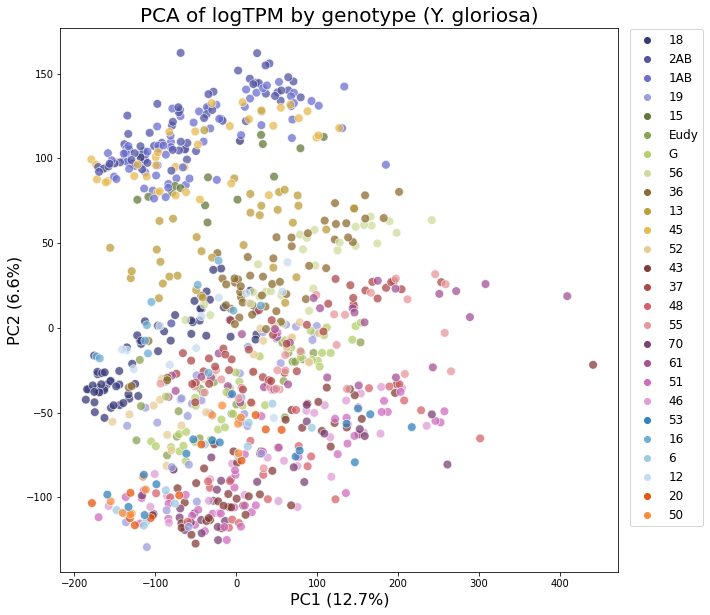

In [22]:
plotpca_genotype(plot_yg,"./pca_plots/subset_data/PCA_Ygsub_toYgIS_bygenotype.pdf",0.12703223,0.06629084,"(Y. gloriosa)")


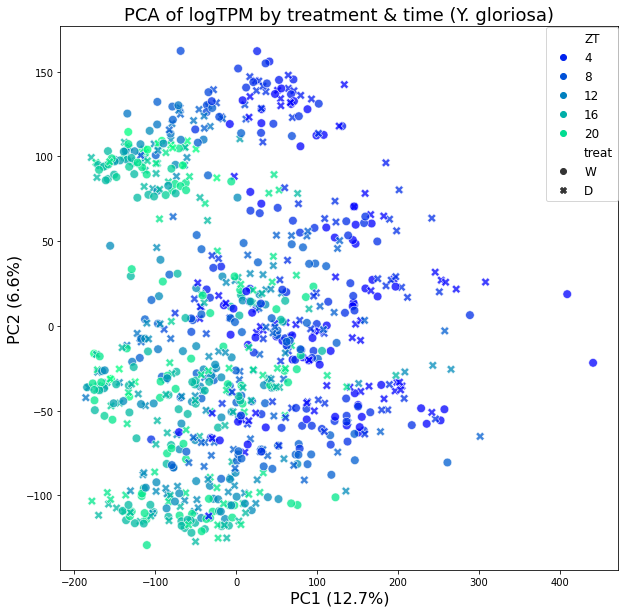

In [24]:
plotpca_treatzt(plot_yg,"./pca_plots/subset_data/PCA_Ygsub_toYgIS_treatZT.pdf",0.12703223,0.06629084,"(Y. gloriosa)")


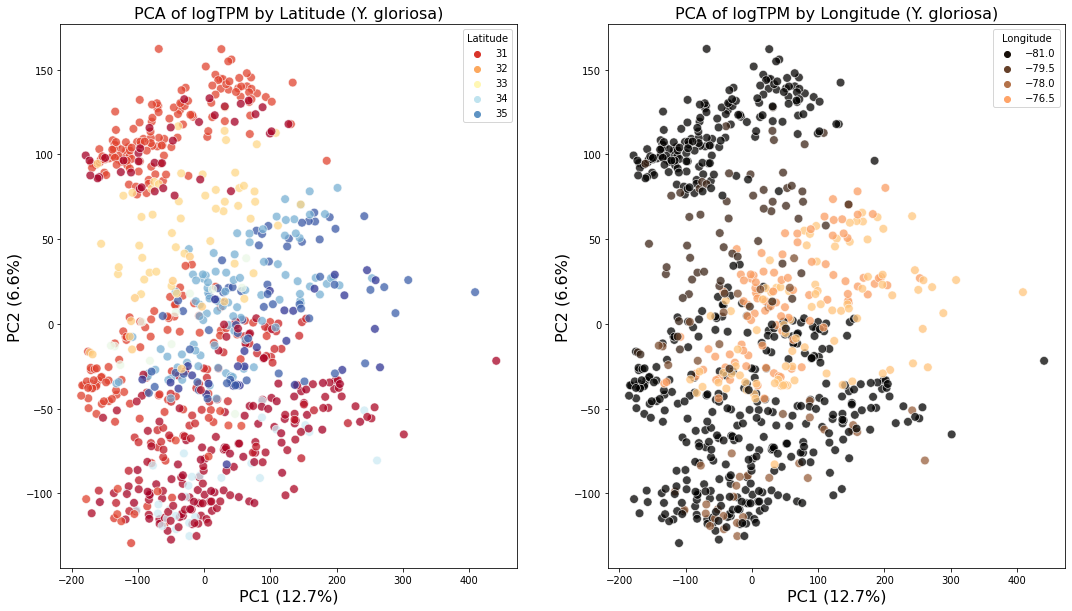

In [27]:
plotpca_latlong(plot_yg,"../SupplementalTable1.csv","./pca_plots/subset_data/PCA_Ygsub_toYgIS_latlong.svg",
               0.12703223,0.06629084,"(Y. gloriosa)")

## Section 3: Run & plot PCA of each genotype

In [28]:
# PCA running function (first 6 PCs) (modified for per-genotype)
def run_pca(vttpm_log_scaled):
    pca = PCA(n_components=6)
    real_PCs = pca.fit_transform(vttpm_log_scaled)
    real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
    print("Explained variance ratio:",pca.explained_variance_ratio_)
    evr = list(pca.explained_variance_ratio_)
    return real_PCs_df, evr[0], evr[1]

In [29]:
def pca_genotype(gt,tpmdf):
    tpmgt = tpmdf[tpmdf["genotype"]==gt]
    vtlog_scaled, vtlog = tpm_prep(tpmgt)
    pca,ev1,ev2 = run_pca(vtlog_scaled)
    plot = make_plotdata(vtlog,tpmgt,pca)
    fn = "./pca_plots/subset_data/by_genotype/PCA_Ygsub_toYgIS_treatZT_"+str(gt)
    plotpca_treatzt(plot,fn,ev1,ev2,"(Y. gloriosa genotype "+gt+")")

In [30]:
for g in list(ygtpm["genotype"].unique()):
    print("\n"+g)
    pca_genotype(g,ygtpm)
    plt.clf()


18
Number of zero-variance genes removed: 5415
Explained variance ratio: [0.13085034 0.09346422 0.07198777 0.05353186 0.04707481 0.03500924]

2AB
Number of zero-variance genes removed: 7489
Explained variance ratio: [0.14368592 0.09701428 0.06733848 0.04738679 0.0335366  0.0285518 ]

1AB
Number of zero-variance genes removed: 7173
Explained variance ratio: [0.15880941 0.09177252 0.05915811 0.04087647 0.0352316  0.03484554]

19
Number of zero-variance genes removed: 7154
Explained variance ratio: [0.1517115  0.11386223 0.0932148  0.06765019 0.04854527 0.04510194]

15
Number of zero-variance genes removed: 9856
Explained variance ratio: [0.19051352 0.13639776 0.1183343  0.09131085 0.07519323 0.06128892]

Eudy
Number of zero-variance genes removed: 8623
Explained variance ratio: [0.18893705 0.11669375 0.0968639  0.06645088 0.06200622 0.05334401]

G
Number of zero-variance genes removed: 8762
Explained variance ratio: [0.17583982 0.10464706 0.07008029 0.04745617 0.04532747 0.04129118]

56

/tmp/ipykernel_111/3341617572.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(10,10))



16
Number of zero-variance genes removed: 11035
Explained variance ratio: [0.22273627 0.19240847 0.1342162  0.11379601 0.08278509 0.06324098]

6
Number of zero-variance genes removed: 10795
Explained variance ratio: [0.27335371 0.19128174 0.10303988 0.09632627 0.06492356 0.05823503]

12
Number of zero-variance genes removed: 9172
Explained variance ratio: [0.25367552 0.18104069 0.13097983 0.09629221 0.0675679  0.06469197]

20
Number of zero-variance genes removed: 11043
Explained variance ratio: [0.27123778 0.20036818 0.11854735 0.09591501 0.07471975 0.05678428]

50
Number of zero-variance genes removed: 11619
Explained variance ratio: [0.24724008 0.18948115 0.12729533 0.09208124 0.0714585  0.06256869]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>